# 🧠 Professional Bitcoin Directional Prediction using Deep Learning (MLP)
## Multi-Layer Perceptron Optimized for Hourly BTC/USDT Analysis

This notebook implements a state-of-the-art **Deep Neural Network (MLP)** for Bitcoin price direction prediction. MLPs capture complex non-linear relationships that traditional ML models may miss.

### Objectives:
1. **Advanced Architecture Design**: Build a robust neural network with dropout and batch normalization
2. **Data Pipeline**: Sequence engineering with LSTM-compatible preprocessing
3. **Feature Selection**: SelectKBest with correlation filtering
4. **Optimization**: Adam optimizer with learning rate scheduling
5. **Regularization**: Dropout, L2, Early Stopping to prevent overfitting
6. **Performance Evaluation**: Classification metrics and financial backtesting
7. **Production Export**: Model checkpointing and metadata saving

---
## 1. Environment Setup & Data Loading
Importing libraries and configuring the visualization style.

In [1]:
# ==============================
# Imports & Environment Setup
# ==============================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib
import json
import datetime
import warnings

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks, optimizers, regularizers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score

warnings.filterwarnings('ignore')
plt.style.use('dark_background')
tf.random.set_seed(42)
np.random.seed(42)

# ======================
# 1. Local Dataset Path
# ======================
FILE_PATH = "../data/features/btc_features_complete.csv"

if not os.path.exists(FILE_PATH):
    raise FileNotFoundError(f"❌ Dataset not found at: {FILE_PATH}")

# Load Dataset
df_raw = pd.read_csv(FILE_PATH)
print(f'✅ Dataset loaded successfully. Shape: {df_raw.shape}')
print(f'\n📋 Column preview:')
print(df_raw.columns.tolist()[:10])
print(f'\nℹ️  Dataset info:')
print(df_raw.info())
print(f'Shape: {df_raw.shape}')

# ======================
# 2. Configuration
# ======================
MODEL_NAME = "mlp"
COLORS = ['#F7931A', '#00FF9C', '#FF4C4C']
MODEL_SAVE_PATH = f"../models/{MODEL_NAME}/btc_{MODEL_NAME}_hourly_model.h5"
METADATA_SAVE_PATH = f"../models/{MODEL_NAME}/btc_{MODEL_NAME}_hourly_metadata.json"
SCALER_SAVE_PATH = f"../models/{MODEL_NAME}/btc_{MODEL_NAME}_hourly_scaler.pkl"

os.makedirs(os.path.dirname(MODEL_SAVE_PATH), exist_ok=True)

✅ Dataset loaded successfully. Shape: (69861, 71)

📋 Column preview:
['Datetime', 'Open', 'High', 'Low', 'Close', 'Volume', 'returns', 'log_returns', 'future_return_1h', 'future_return_6h']

ℹ️  Dataset info:
<class 'pandas.DataFrame'>
RangeIndex: 69861 entries, 0 to 69860
Data columns (total 71 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Datetime            69861 non-null  str    
 1   Open                69861 non-null  float64
 2   High                69861 non-null  float64
 3   Low                 69861 non-null  float64
 4   Close               69861 non-null  float64
 5   Volume              69861 non-null  float64
 6   returns             69861 non-null  float64
 7   log_returns         69861 non-null  float64
 8   future_return_1h    69861 non-null  float64
 9   future_return_6h    69861 non-null  float64
 10  future_return_24h   69861 non-null  float64
 11  momentum_24h        69861 non-null  float64
 12  mo

---
## 2. Preprocessing & Sequence Engineering
Preparing data with lag features for temporal context.

In [2]:
def load_and_preprocess(path):
    df = pd.read_csv(path, index_col=0, parse_dates=True)
    df = df.select_dtypes(include=[np.number])

    # Engineering lags for the top technical indicators
    target_lags = ['returns', 'RSI_14', 'MACD_hist', 'Close', 'Volume']
    existing_lags = [f for f in target_lags if f in df.columns]

    for f in existing_lags:
        for lag in range(1, 6):
            df[f'{f}_lag_{lag}'] = df[f].shift(lag)

    return df.ffill().bfill().dropna()

df = load_and_preprocess(FILE_PATH)
print(f'Processing complete. Total features (with lags): {len(df.columns)}')
print(f'Shape after preprocessing: {df.shape}')

Processing complete. Total features (with lags): 94
Shape after preprocessing: (69861, 94)


---
## 3. Advanced Feature Selection
Using SelectKBest + correlation filtering for feature importance ranking.

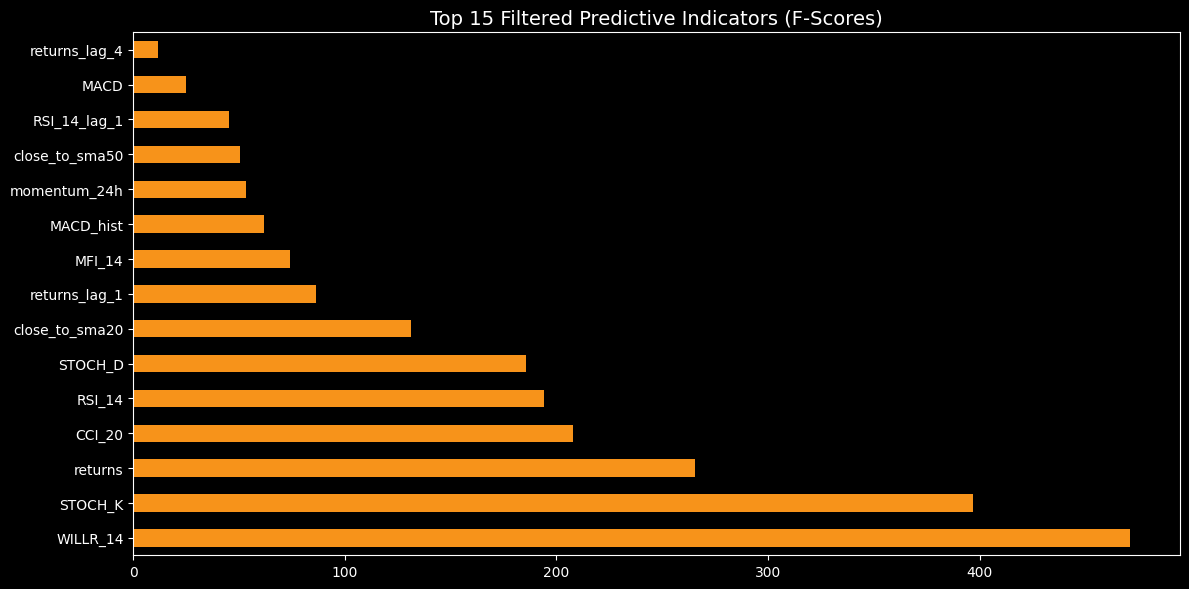

Selected Top 30 Features for MLP: ['Open', 'returns', 'momentum_24h', 'MACD', 'MACD_hist', 'RSI_14', 'STOCH_K', 'STOCH_D', 'ADX_14', 'CCI_20']...


In [3]:
def select_features(df, k=30):
    target = 'target_direction'

    # CRITICAL: Exclude future-looking columns
    X_raw = df.drop([c for c in df.columns if 'target' in c.lower() or 'future' in c.lower()], axis=1)
    y = df[target]

    # Univariate selection
    selector = SelectKBest(score_func=f_classif, k=min(k*2, X_raw.shape[1]))
    selector.fit(X_raw, y)
    top_raw_cols = X_raw.columns[selector.get_support()]

    # Multicollinearity Filter: Keep only one feature from highly correlated pairs
    corr_matrix = X_raw[top_raw_cols].corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

    final_cols = [c for c in top_raw_cols if c not in to_drop][:k]

    # Visualization
    scores = pd.Series(selector.scores_, index=X_raw.columns).loc[final_cols].sort_values(ascending=False).head(15)
    scores.plot(kind='barh', color=COLORS[0], figsize=(12, 6))
    plt.title('Top 15 Filtered Predictive Indicators (F-Scores)', fontsize=14)
    plt.tight_layout()
    plt.show()

    return final_cols

top_features = select_features(df, k=30)
print(f'Selected Top {len(top_features)} Features for MLP: {list(top_features[:10])}...')

---
## 4. Data Preparation & Scaling
Splitting data and applying StandardScaler for optimal neural network Performance.

In [4]:
# Prepare arrays
X = df[top_features]
y = df['target_direction']

# 80% sequential split (no data leakage)
cutoff = int(len(X) * 0.8)
X_train, X_test = X.iloc[:cutoff], X.iloc[cutoff:]
y_train, y_test = y.iloc[:cutoff], y.iloc[cutoff:]

# Scaling is CRITICAL for neural networks
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert to float32 for TensorFlow
X_train_scaled = X_train_scaled.astype('float32')
X_test_scaled = X_test_scaled.astype('float32')
y_train_array = y_train.values.astype('float32')
y_test_array = y_test.values.astype('float32')

print(f"Training set shape: {X_train_scaled.shape}")
print(f"Test set shape: {X_test_scaled.shape}")
print(f"Class distribution (Train): {np.bincount(y_train.values)}")
print(f"Class distribution (Test): {np.bincount(y_test.values)}")

Training set shape: (55888, 30)
Test set shape: (13973, 30)
Class distribution (Train): [27439 28449]
Class distribution (Test): [6900 7073]


---
## 5. Deep Neural Network Architecture
Building a robust MLP with dropout, batch normalization, and L2 regularization.

In [5]:
def create_mlp_model(input_dim, l2_factor=1e-4):
    """
    Create a deep neural network optimized for binary classification.

    Architecture:
    - Input: 30 features (scaled)
    - Hidden Layer 1: 256 neurons + BatchNorm + Dropout
    - Hidden Layer 2: 128 neurons + BatchNorm + Dropout
    - Hidden Layer 3: 64 neurons + BatchNorm + Dropout
    - Hidden Layer 4: 32 neurons + BatchNorm + Dropout
    - Output: 1 neuron (sigmoid for binary classification)
    """
    model = Sequential([
        # Input layer
        Input(shape=(input_dim,)),

        # First block: Dense -> BatchNorm -> Dropout
        Dense(256, activation='relu', kernel_regularizer=regularizers.L2(l2_factor)),
        BatchNormalization(),
        Dropout(0.3),

        # Second block
        Dense(128, activation='relu', kernel_regularizer=regularizers.L2(l2_factor)),
        BatchNormalization(),
        Dropout(0.3),

        # Third block
        Dense(64, activation='relu', kernel_regularizer=regularizers.L2(l2_factor)),
        BatchNormalization(),
        Dropout(0.25),

        # Fourth block
        Dense(32, activation='relu', kernel_regularizer=regularizers.L2(l2_factor)),
        BatchNormalization(),
        Dropout(0.2),

        # Output layer
        Dense(1, activation='sigmoid')
    ])

    return model

model = create_mlp_model(input_dim=X_train_scaled.shape[1])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │         7,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 53,121 (207.50 KB)

 Trainable params: 52,161 (203.75 KB)

 Non-trainable params: 960 (3.75 KB)

---
## 6. Model Compilation & Callbacks
Using Adam optimizer with learning rate scheduling and early stopping.

In [6]:
# Compile model
optimizer = Adam(learning_rate=0.001)
model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC()]
)

# Callbacks for optimization
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

checkpoint = ModelCheckpoint(
    filepath=MODEL_SAVE_PATH.replace('.h5', '_best.h5'),
    monitor='val_accuracy',
    save_best_only=True,
    verbose=0
)

print('✅ Model compiled and callbacks configured')

✅ Model compiled and callbacks configured


---
## 7. Model Training
Training the MLP with validation split and progress monitoring.

In [7]:
print("🔍 Training Deep Neural Network...")

history = model.fit(
    X_train_scaled, y_train_array,
    validation_split=0.2,  # 20% of training for validation
    epochs=150,
    batch_size=32,
    callbacks=[early_stop, reduce_lr, checkpoint],
    verbose=1
)

print(f"✅ Training complete. Best epoch: {len(history.history['loss']) - early_stop.patience}")

🔍 Training Deep Neural Network...
Epoch 1/150
1398/1398 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5140 - auc: 0.5158 - loss: 0.7801

1398/1398 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.5179 - auc: 0.5228 - loss: 0.7501 - val_accuracy: 0.5389 - val_auc: 0.5557 - val_loss: 0.7234 - learning_rate: 0.0010
Epoch 2/150
1394/1398 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5368 - auc: 0.5469 - loss: 0.7247

1398/1398 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.5405 - auc: 0.5536 - loss: 0.7224 - val_accuracy: 0.5471 - val_auc: 0.5579 - val_loss: 0.7193 - learning_rate: 0.0010
Epoch 3/150
1387/1398 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5463 - auc: 0.5579 - loss: 0.7179

1398/1398 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.5475 - auc: 0.5599 - loss: 0.7161 - val_accuracy: 0.5522 - val_auc: 0.5656 - val_loss: 0.7121 - learning_rate: 0.0010
Epoch 4/150
1398/1398 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5507 - auc: 0.5658 - loss: 0.7090 - val_accuracy: 0.5472 - val_auc: 0.5638 - val_loss: 0.7068 - learning_rate: 0.0010
Epoch 5/150
1398/1398 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.5512 - auc: 0.5654 - loss: 0.7032 - val_accuracy: 0.5473 - val_auc: 0.5640 - val_loss: 0.7012 - learning_rate: 0.0010
Epoch 6/150
1398/1398 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.5516 - auc: 0.5664 - loss: 0.6984 - val_accuracy: 0.5478 - val_auc: 0.5612 - val_loss: 0.6988 - learning_rate: 0.0010
Epoch 7/150
1398/1398 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.5515 - auc: 0.5678 - loss: 0.6957 - val_accuracy: 0.5469 - val_auc: 0.5626 - val_loss: 0.6964 - learning_rate: 0.0010
Epoch 8/150
1398/1398 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.5541 - 

---
## 8. Model Evaluation & Visualization
Analyzing training history and test Performance.

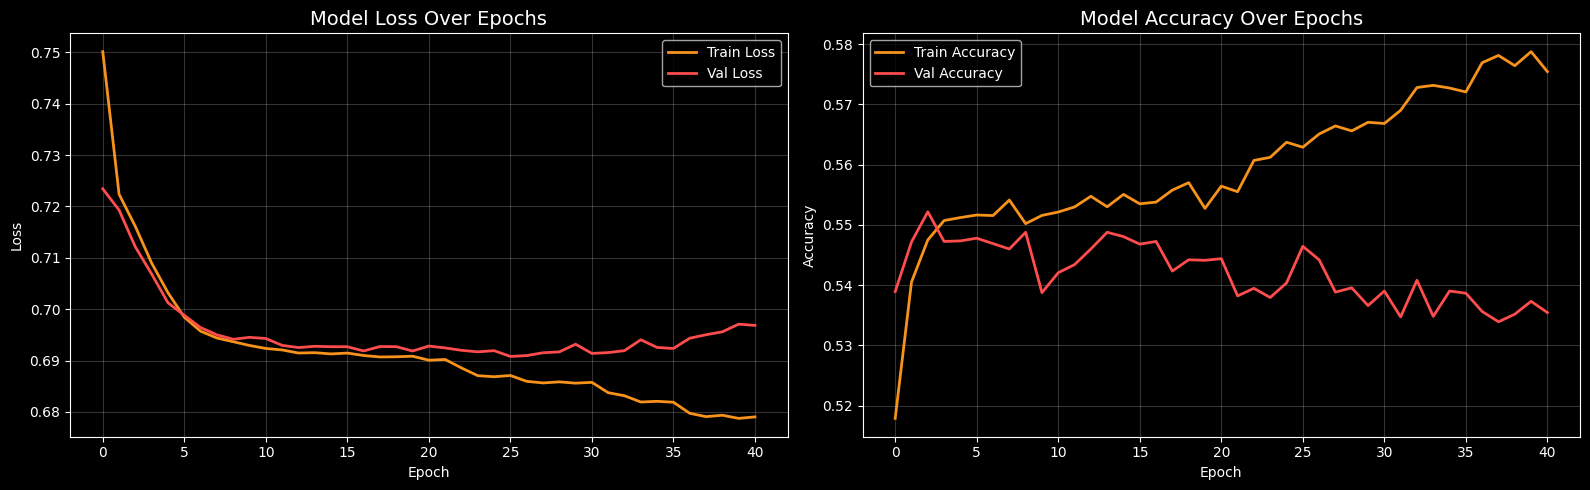

Final Training Accuracy: 0.5754
Final Validation Accuracy: 0.5354


In [8]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Loss
axes[0].plot(history.history['loss'], label='Train Loss', color=COLORS[0], linewidth=2)
axes[0].plot(history.history['val_loss'], label='Val Loss', color=COLORS[2], linewidth=2)
axes[0].set_title('Model Loss Over Epochs', fontsize=14)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.2)

# Accuracy
axes[1].plot(history.history['accuracy'], label='Train Accuracy', color=COLORS[0], linewidth=2)
axes[1].plot(history.history['val_accuracy'], label='Val Accuracy', color=COLORS[2], linewidth=2)
axes[1].set_title('Model Accuracy Over Epochs', fontsize=14)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.2)

plt.tight_layout()
plt.show()

print(f"Final Training Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")

---
## 9. Test Set Evaluation
Comprehensive classification metrics on hold-out test set.

📈 Test Set Performance
Accuracy:  0.5239
AUC-ROC:   0.5356

--- Classification Report ---
              precision    recall  f1-score   support

  Baisse (0)       0.51      0.64      0.57      6900
  Hausse (1)       0.54      0.41      0.47      7073

    accuracy                           0.52     13973
   macro avg       0.53      0.53      0.52     13973
weighted avg       0.53      0.52      0.52     13973



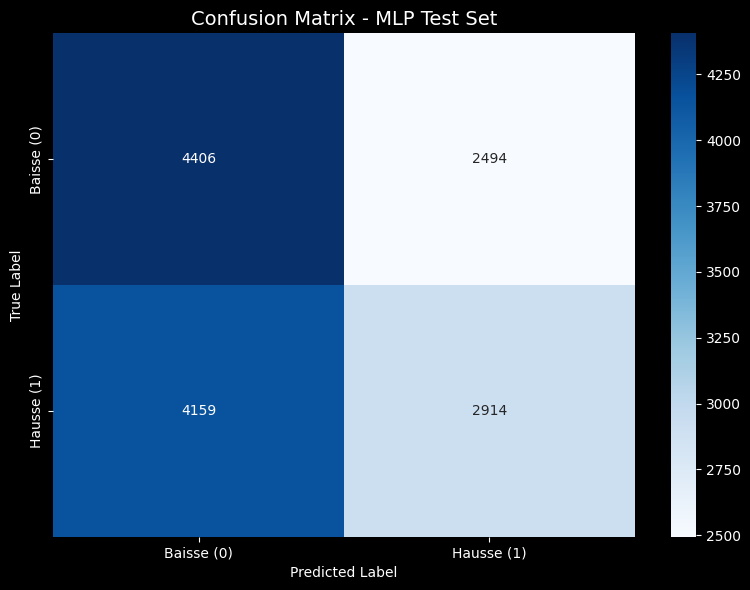

In [9]:
# Predictions on test set
y_pred_proba = model.predict(X_test_scaled, verbose=0)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()

# Metrics
acc = accuracy_score(y_test_array, y_pred)
auc = roc_auc_score(y_test_array, y_pred_proba)

print(f"📈 Test Set Performance")
print(f"=============================")
print(f"Accuracy:  {acc:.4f}")
print(f"AUC-ROC:   {auc:.4f}")
print(f"\n--- Classification Report ---")
print(classification_report(y_test_array, y_pred, target_names=['Baisse (0)', 'Hausse (1)']))

# Confusion Matrix
cm = confusion_matrix(y_test_array, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['Baisse (0)', 'Hausse (1)'],
            yticklabels=['Baisse (0)', 'Hausse (1)'])
plt.title('Confusion Matrix - MLP Test Set', fontsize=14)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

---
## 10. Professional Backtest & Risk Analysis
Evaluating financial Performance with Sharpe Ratio and Drawdown metrics.

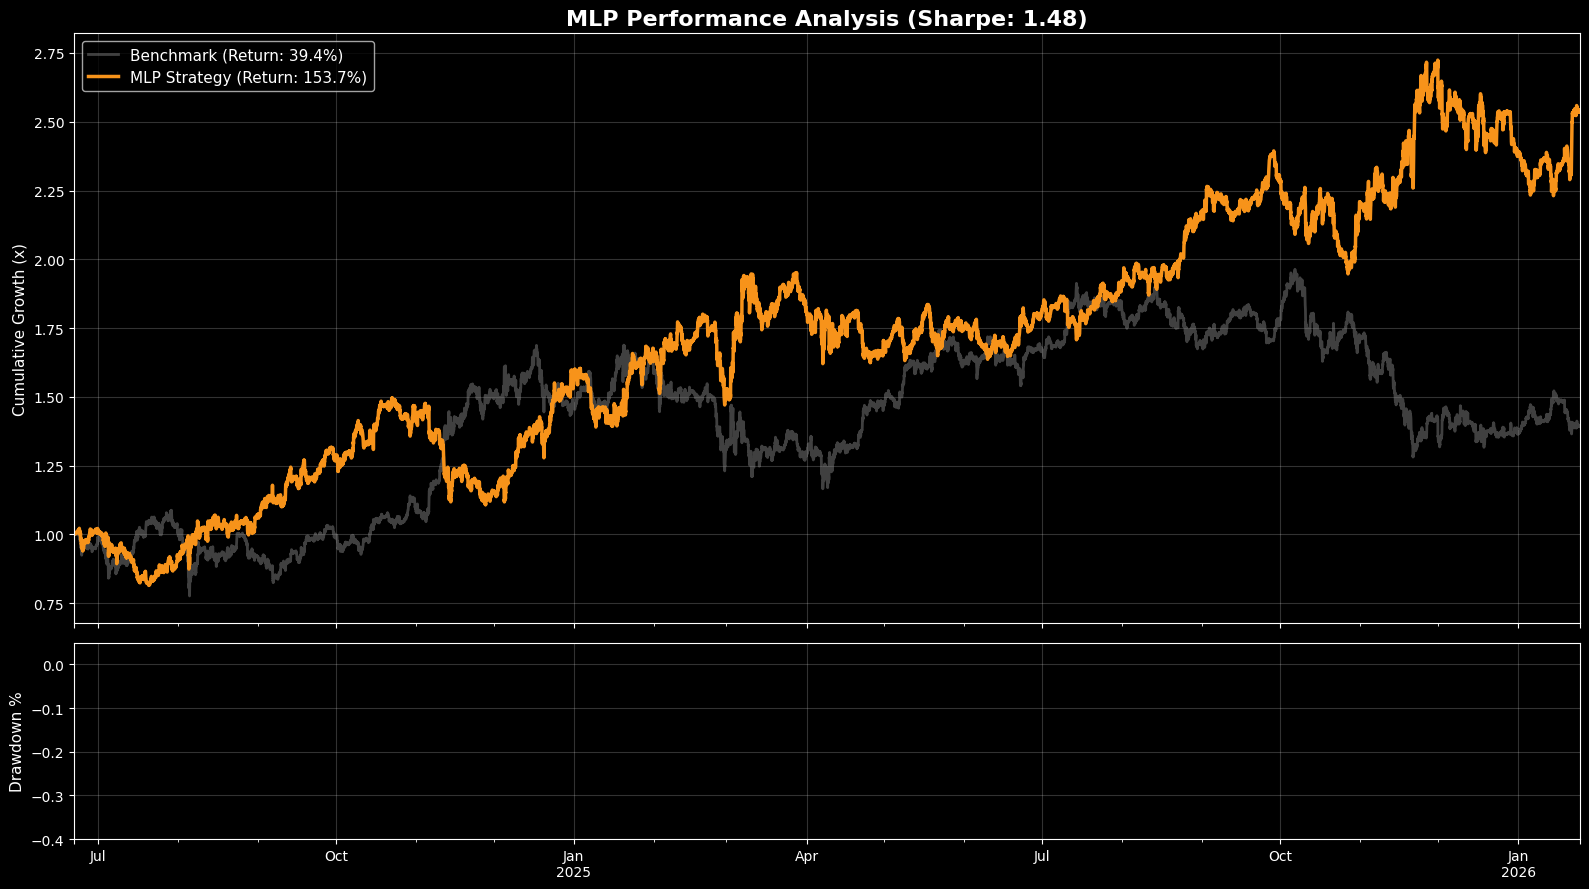


--- MLP Strategy Performance Comparison ---
         Metric Strategy Benchmark
   Total Return   153.7%     39.4%
Ann. Volatility    46.9%     46.9%
   Sharpe Ratio     1.48      0.68
   Max Drawdown   -26.0%    -34.8%


In [10]:
def calculate_metrics(returns):
    sharpe = (returns.mean() / returns.std()) * np.sqrt(24 * 365) if returns.std() != 0 else 0
    cum_ret = (1 + returns).cumprod()
    drawdown = cum_ret / cum_ret.cummax() - 1
    max_dd = drawdown.min()
    vol = returns.std() * np.sqrt(24 * 365)
    return sharpe, max_dd, vol, cum_ret.iloc[-1] - 1 if hasattr(cum_ret, 'iloc') else cum_ret[-1] - 1

def run_professional_backtest(y_test, y_pred, df_full, model_name="MLP"):
    # Extract test period
    test_period = df_full.iloc[-len(y_test):].copy()

    # Signal processing
    test_period['signal'] = np.where(y_pred == 1, 1, -1)
    test_period['strat_ret'] = test_period['signal'].shift(1) * test_period['returns']
    test_period = test_period.dropna()

    # Metrics
    s_sharpe, s_mdd, s_vol, s_ret = calculate_metrics(test_period['strat_ret'])
    b_sharpe, b_mdd, b_vol, b_ret = calculate_metrics(test_period['returns'])

    # Visualization
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(16, 9), gridspec_kw={'height_ratios': [3, 1]})

    ((1 + test_period['returns']).cumprod()).plot(ax=ax1, label=f'Benchmark (Return: {b_ret:.1%})', color='gray', alpha=0.5, linewidth=2)
    ((1 + test_period['strat_ret']).cumprod()).plot(ax=ax1, label=f'{model_name} Strategy (Return: {s_ret:.1%})', color=COLORS[0], linewidth=2.5)
    ax1.set_title(f'{model_name} Performance Analysis (Sharpe: {s_sharpe:.2f})', fontsize=16, fontweight='bold')
    ax1.legend(loc='upper left', fontsize=11)
    ax1.set_ylabel('Cumulative Growth (x)', fontsize=11)
    ax1.grid(True, alpha=0.2)

    # Drawdown
    dd = (1 + test_period['strat_ret']).cumprod() / (1 + test_period['strat_ret']).cumprod().cummax() - 1
    ax2.fill_between(dd.index, dd, 0, color=COLORS[2], alpha=0.4)
    ax2.set_ylabel('Drawdown %', fontsize=11)
    ax2.set_ylim(-0.40, 0.05)
    ax2.grid(True, alpha=0.2)

    plt.tight_layout()
    plt.show()

    # Performance Summary
    stats = pd.DataFrame({
        'Metric': ['Total Return', 'Ann. Volatility', 'Sharpe Ratio', 'Max Drawdown'],
        'Strategy': [f"{s_ret:.1%}", f"{s_vol:.1%}", f"{s_sharpe:.2f}", f"{s_mdd:.1%}"],
        'Benchmark': [f"{b_ret:.1%}", f"{b_vol:.1%}", f"{b_sharpe:.2f}", f"{b_mdd:.1%}"]
    })

    print(f"\n--- {model_name} Strategy Performance Comparison ---")
    print(stats.to_string(index=False))

    return s_sharpe, s_mdd, s_vol, s_ret

# Run backtest
sharpe, max_dd, vol, total_ret = run_professional_backtest(y_test, y_pred, df, model_name="MLP")

---
## 11. Model Persistence & Metadata
Saving the trained model and comprehensive metadata for production deployment.

In [11]:
# Create directory if not exists
os.makedirs(os.path.dirname(MODEL_SAVE_PATH), exist_ok=True)

# Save the trained model
model.save(MODEL_SAVE_PATH)
print(f"✅ Model saved to {MODEL_SAVE_PATH}")

# Save the scaler
joblib.dump(scaler, SCALER_SAVE_PATH)
print(f"✅ Scaler saved to {SCALER_SAVE_PATH}")

# Prepare metadata
metadata = {
    "model_name": "MLP Bitcoin Directional Predictor",
    "model_type": "Deep Neural Network (Multi-Layer Perceptron)",
    "accuracy": float(acc),
    "auc_roc": float(auc),
    "sharpe_ratio": float(sharpe),
    "max_drawdown": float(max_dd),
    "total_return_backtest": float(total_ret),
    "Architecture": {
        "layers": [
            "Input: 30 features (scaled)",
            "Dense(256) + BatchNorm + Dropout(0.3)",
            "Dense(128) + BatchNorm + Dropout(0.3)",
            "Dense(64) + BatchNorm + Dropout(0.25)",
            "Dense(32) + BatchNorm + Dropout(0.2)",
            "Output: Dense(1, sigmoid)"
        ],
        "total_parameters": int(model.count_params()),
        "trainable_parameters": int(sum([tf.size(w).numpy() for w in model.trainable_weights]))
    },
    "training_config": {
        "optimizer": "Adam",
        "learning_rate": 0.001,
        "loss_function": "binary_crossentropy",
        "batch_size": 32,
        "max_epochs": 150,
        "early_stopping_patience": 15,
        "l2_regularization": 1e-4
    },
    "data_config": {
        "training_size": len(X_train),
        "test_size": len(X_test),
        "validation_split": 0.2,
        "number_of_features": len(top_features),
        "feature_names": list(top_features)
    },
    "performance_metrics": {
        "test_accuracy": float(acc),
        "test_auc": float(auc),
        "test_loss": float(model.evaluate(X_test_scaled, y_test_array, verbose=0)[0])
    },
    "export_timestamp": datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
}

# Save metadata
with open(METADATA_SAVE_PATH, 'w') as f:
    json.dump(metadata, f, indent=4)

print(f"✅ Metadata saved to {METADATA_SAVE_PATH}")
print(f"\n📊 Model Summary:")
print(f"   Model Name: {metadata['model_name']}")
print(f"   Test Accuracy: {metadata['performance_metrics']['test_accuracy']:.4f}")
print(f"   Test AUC-ROC: {metadata['performance_metrics']['test_auc']:.4f}")
print(f"   Total Parameters: {metadata['Architecture']['total_parameters']:,}")
print(f"   Sharpe Ratio (Backtest): {sharpe:.3f}")
print(f"   Max Drawdown (Backtest): {max_dd:.2%}")
print(f"   Total Return (Backtest): {total_ret:.2%}")

✅ Model saved to ../models/mlp/btc_mlp_hourly_model.h5
✅ Scaler saved to ../models/mlp/btc_mlp_hourly_scaler.pkl
✅ Metadata saved to ../models/mlp/btc_mlp_hourly_metadata.json

📊 Model Summary:
   Model Name: MLP Bitcoin Directional Predictor
   Test Accuracy: 0.5239
   Test AUC-ROC: 0.5356
   Total Parameters: 53,121
   Sharpe Ratio (Backtest): 1.480
   Max Drawdown (Backtest): -25.97%
   Total Return (Backtest): 153.74%
